In [1]:
# !pip install pmdarima

In [2]:
# !pip install klib

In [3]:
# !pip install pandas_profiling

**ARIMA, AUTO ARIMA, SARIMA**

**Import Library**

In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import klib
# from pandas_profiling import ProfileReport

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import itertools
import math

from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# from pylab import rcParams
# from sklearn import model_selection
# from sklearn.model_selection import train_test_split

**Load the Data**

In [5]:
filename = 'data.csv'
df = pd.read_csv(filename, sep= ';')
df.drop(['PRODUCT_CATEGORY','TRANSACTIONS','STORE_CODE'], axis=1, inplace=True)
df['DATE'] =  pd.to_datetime(df['DATE'])
start_date = '2016-05-18'
end_date = '2019-06-18'
df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]
df['QTY'] = abs(df['QTY'])
#df = df.set_index('DATE')
df = df.sort_values(by='DATE')
df = df.groupby(by=['DATE'], as_index=False).sum()
df

,DATE,QTY
0,2016-05-18,114
1,2016-05-19,96
2,2016-05-20,146
3,2016-05-21,211
4,2016-05-22,42
...,...,...
1039,2019-06-14,207
1040,2019-06-15,263
1041,2019-06-16,75
1042,2019-06-17,203


**Exploratory Data Analysis**

In [6]:
df['year'] = df['DATE'].dt.year
df['month'] = df['DATE'].dt.month
df['day'] = df['DATE'].dt.dayofyear
df['weekday'] = df['DATE'].dt.weekday
df['year-month'] = df['DATE'].apply(lambda x: str(x.year)+'-'+str(x.month))

<Axes: title={'center': 'Total Sales'}, xlabel='year-month', ylabel='QTY'>

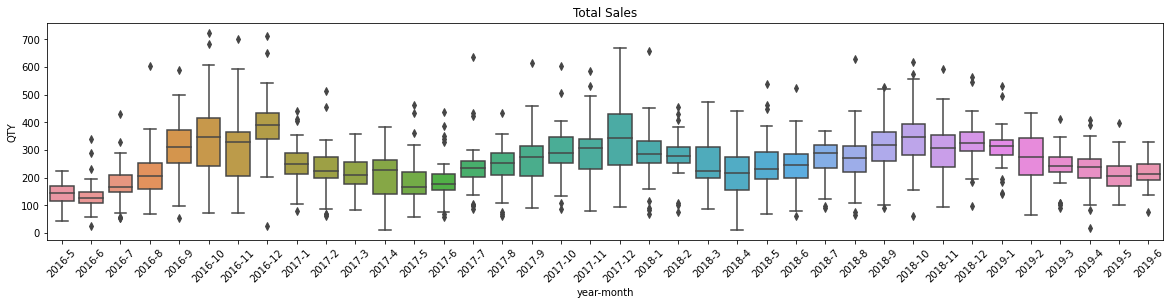

In [7]:
plt.figure(figsize=(20,4))
plt.xticks(rotation=45)
plt.title('Total Sales')
sns.boxplot(x="year-month", y="QTY", data=df)

<Axes: title={'center': 'Sales per month.'}, xlabel='month', ylabel='QTY'>

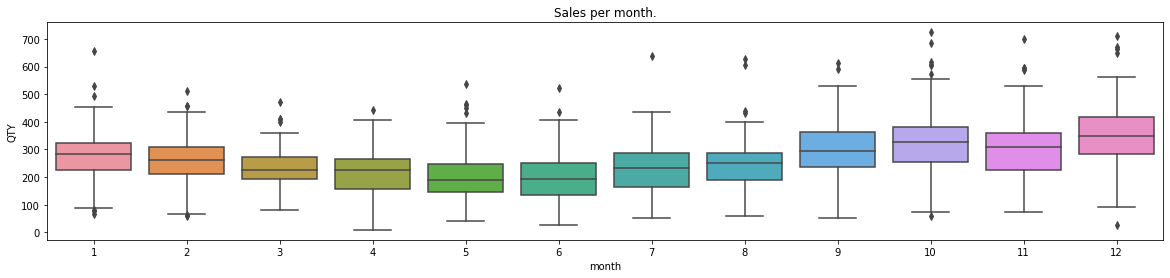

In [8]:
plt.figure(figsize=(20,4))
plt.title("Sales per month.")
sns.boxplot(x="month", y="QTY", data=df)

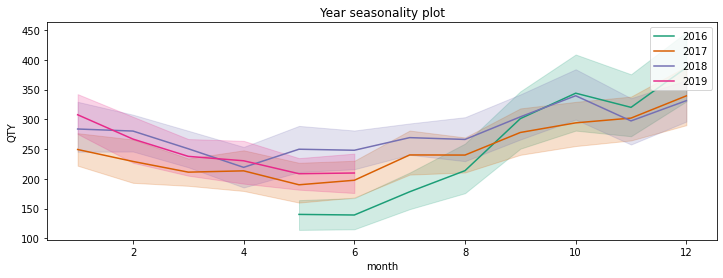

In [9]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=df,
             x='month',
             y='QTY',
             hue='year',
             legend='full',
            palette='Dark2')
plt.title('Year seasonality plot')
plt.legend(bbox_to_anchor=(1, 1), loc=1);

**Detecting Outliers**

In [10]:
# from scipy.stats import zscore
# z_scores = zscore(df['QTY'])
# outliers = (z_scores > 2) | (z_scores < -2)
# outlier_indices = df.index[outliers]
# print("Detected outliers:", outlier_indices)
# total_outliers = len(outlier_indices)
# print("Total number of outliers:", total_outliers)

In [11]:
# plt.figure(figsize=(10, 5))
# plt.plot(df.index, df['QTY'], label='Original Data', marker='o')
# plt.scatter(outlier_indices, df.loc[outlier_indices, 'QTY'], c='red', label='Outliers', marker='x', s=100)
# plt.xlabel('Index')
# plt.ylabel('QTY')
# plt.title('Outlier Detection using Z-Score')
# plt.legend()
# plt.show()

In [12]:
# Remove outliers from the DataFrame
# df = df.drop(outlier_indices)
# df

**Checking Distribution of the Data**

In [13]:
df = df.set_index('DATE')

In [14]:
df.drop(['year','month','day','weekday','year-month'], axis=1, inplace=True)

<Axes: xlabel='QTY', ylabel='Density'>

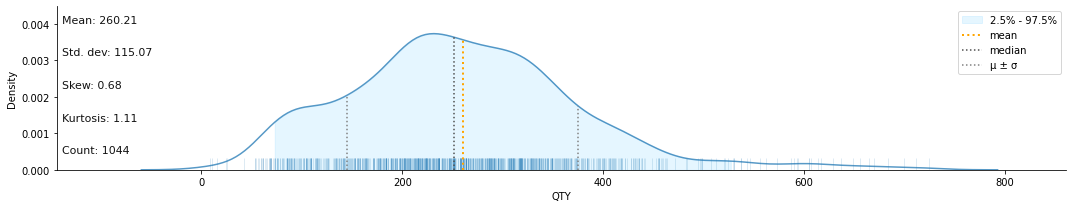

In [15]:
klib.dist_plot(df)

**Rolling mean and standard deviation**

In [16]:
# def plot_rolling(df, interval):
# rolmean = df.rolling(interval).mean()
# rolstd = df.rolling(interval).std()
# plt.figure(figsize=(12, 4))
# plt.xlabel('Date')
# orig = plt.plot(df, color='blue',label='Original')
# mean = plt.plot(rolmean, color='red', label='Rolling Mean')
# std = plt.plot(rolstd, color='black', label = 'Rolling Std')
# plt.legend(loc='best')
# plt.show()
# plot_rolling(df, 90)


**Augmented Dickey-Fuller Test**

In [17]:
# original_data = df['QTY']
# first_diff = df.diff().dropna()['QTY']
# result_original = adfuller(original_data)
# print(f'Original Data ADF Statistic: {result_original[0]:.3f}')
# print(f'Original Data p-value: {result_original[1]:.3f}')
# result_diff = adfuller(first_diff)
# print(f'1st Differencing ADF Statistic: {result_diff[0]:.3f}')
# print(f'1st Differencing p-value: {result_diff[1]:.3f}')

In [18]:
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(df['QTY'], label='Original Data')
# plt.axhline(y=df['QTY'].mean(), color='r', linestyle='--', label='Mean')
# plt.axhline(y=df['QTY'].std(), color='g', linestyle='--', label='Standard Deviation')
# plt.title(f'Original Time Series Data\nADF Statistic: {result_original[0]:.3f}, p-value: {result_original[1]:.3f}')
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(first_diff, label='1st Differenced Data')
# plt.axhline(y=first_diff.mean(), color='r', linestyle='--', label='Mean')
# plt.axhline(y=first_diff.std(), color='g', linestyle='--', label='Standard Deviation')
# plt.title(f'1st Differenced Time Series Data\nADF Statistic: {result_diff[0]:.3f}, p-value: {result_diff[1]:.3f}')
# plt.legend()

# plt.tight_layout()
# plt.show()

**Splitting the Data**

In [19]:
split_index = int(len(df) * 0.8)
salesbyday_train = df.iloc[:split_index]
salesbyday_test = df.iloc[split_index:]
print("Dataset size:", len(df))
print("Train dataset size:", len(salesbyday_train))
print("Validation dataset size:", len(salesbyday_test))

Dataset size: 1044
Train dataset size: 835
Validation dataset size: 209


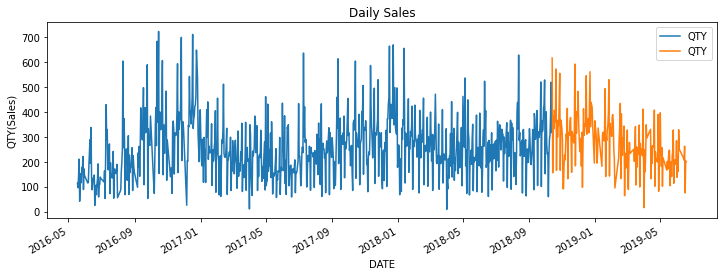

In [20]:
fig, ax = plt.subplots()
salesbyday_train.plot(ax=ax, figsize=(12,4))
salesbyday_test.plot(ax=ax)
plt.title('Daily Sales')
plt.xlabel('DATE')
plt.ylabel('QTY(Sales)')
plt.show()

**Decomposition Plot**

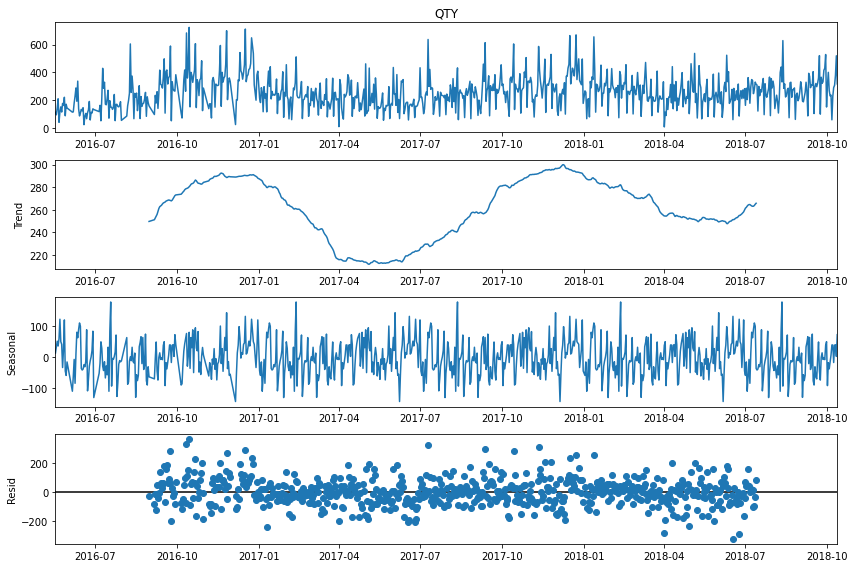

In [21]:
decomp_results = sm.tsa.seasonal_decompose(salesbyday_train['QTY'],model='additive', period=180)
plt.rcParams["figure.figsize"] = (12,8)
decomp_results.plot()
plt.show()

**Autocorrelaion**

In [22]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 8))
# sm.graphics.tsa.plot_acf(salesbyday_train.squeeze(),ax=ax[0])
# sm.graphics.tsa.plot_pacf(salesbyday_train.squeeze(),ax=ax[1])

**Checking Stationarity**

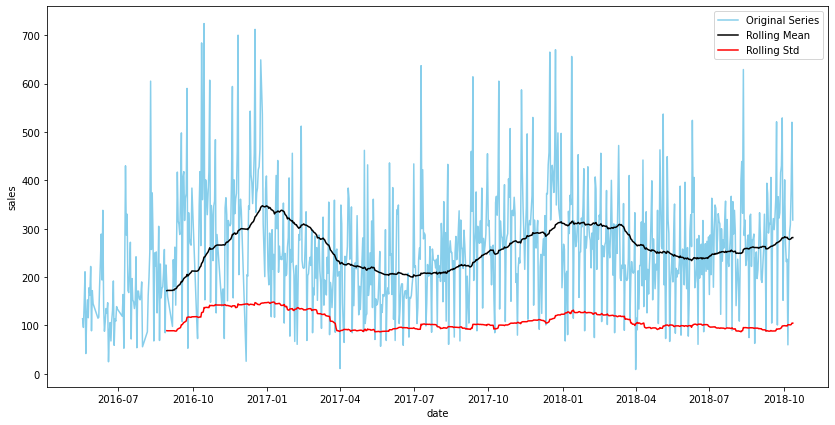

Test statistic = -6.540
P-value = 0.000
Critical values :
	1%: -3.438272329479064 - The data is  stationary with 99% confidence
	5%: -2.8650369467745573 - The data is  stationary with 95% confidence
	10%: -2.568632068251301 - The data is  stationary with 90% confidence


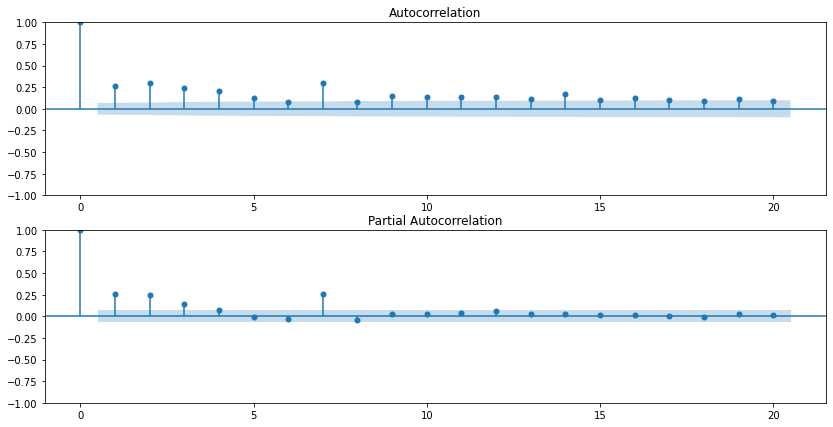

In [23]:
def test_stationarity(timeseries):
    rollmean = timeseries.rolling(window=90).mean()
    rollstd = timeseries.rolling(window=90).std()

    plt.figure(figsize=(14,7))
    plt.plot(timeseries, color='skyblue', label='Original Series')
    plt.plot(rollmean, color='black', label='Rolling Mean')
    plt.plot(rollstd, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('sales')
    plt.show()

    adfuller_test = adfuller(timeseries, autolag='AIC')
    print("Test statistic = {:.3f}".format(adfuller_test[0]))
    print("P-value = {:.3f}".format(adfuller_test[1]))
    print("Critical values :")

    for key, value in adfuller_test[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence"
              .format(key, value, '' if adfuller_test[0] < value else 'not', 100-int(key[:-1])))

    fig, ax = plt.subplots(2, figsize=(14,7))
    ax[0] = sm.graphics.tsa.plot_acf(salesbyday_train, ax=ax[0], lags=20)
    ax[1] = sm.graphics.tsa.plot_pacf(salesbyday_train, ax=ax[1], lags=20)

test_stationarity(salesbyday_train['QTY'])

**Differencing**

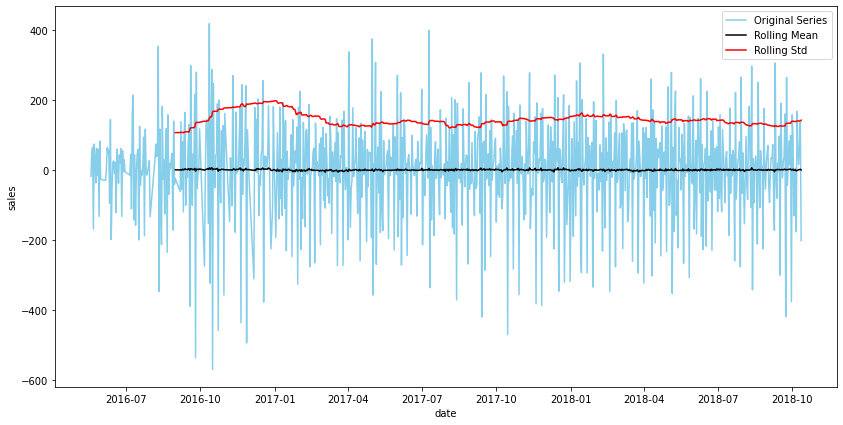

Test statistic = -10.568
P-value = 0.000
Critical values :
	1%: -3.4384289321263126 - The data is  stationary with 99% confidence
	5%: -2.865105979079729 - The data is  stationary with 95% confidence
	10%: -2.568668841575869 - The data is  stationary with 90% confidence


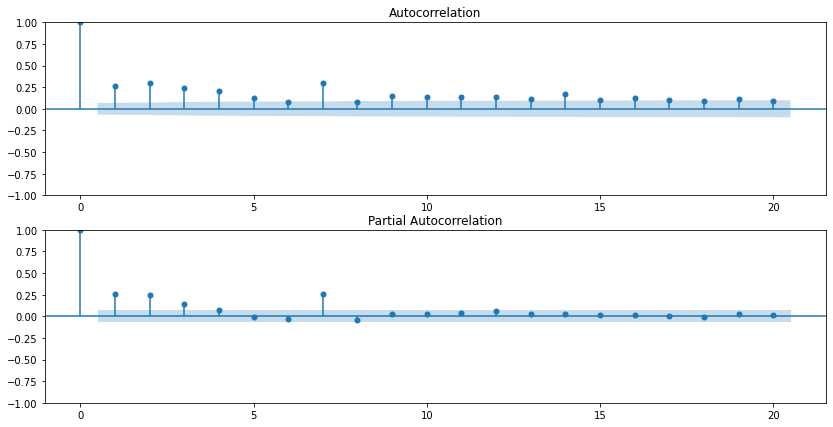

In [24]:
first_difference = salesbyday_train['QTY'] - salesbyday_train['QTY'].shift(1)
first_difference = pd.DataFrame(first_difference.dropna(inplace=False))
test_stationarity(first_difference['QTY'])

**ARIMA**

In [25]:
model_arima = sm.tsa.ARIMA(salesbyday_train, order=(1, 0, 1)).fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                    QTY   No. Observations:                  835
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -5093.711
Date:                Thu, 21 Dec 2023   AIC                          10195.422
Time:                        03:10:11   BIC                          10214.332
Sample:                             0   HQIC                         10202.672
                                - 835                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        256.1712     14.217     18.019      0.000     228.306     284.036
ar.L1          0.9423      0.020     47.021      0.000       0.903       0.982
ma.L1         -0.7997      0.035    -22.599      0.0

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


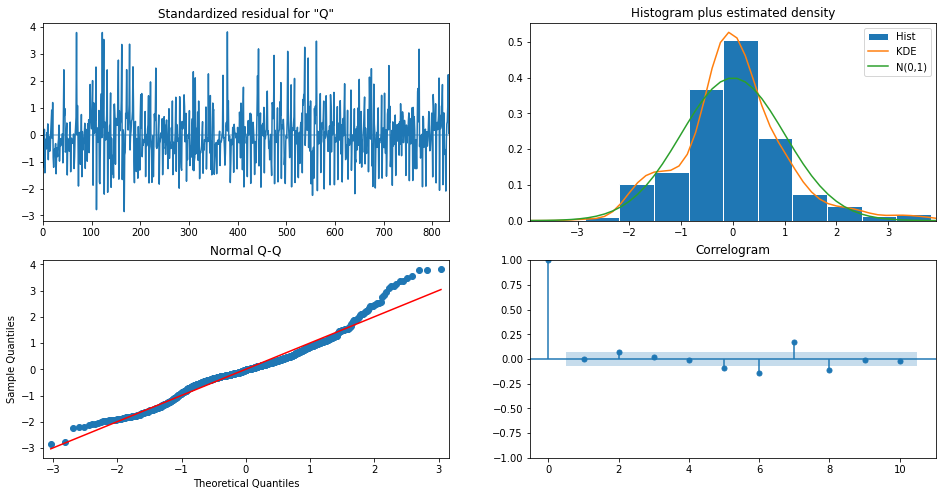

In [26]:
model_arima.plot_diagnostics(figsize=(16,8))
plt.show()

In [27]:
pred_arima_list = model_arima.predict(n_periods=len(salesbyday_test)).tolist()
pred_arima_list_sliced = pred_arima_list[:len(salesbyday_test)]
test_arima_pred = pd.DataFrame({'test': salesbyday_test['QTY'].values.tolist(), 'pred': pred_arima_list_sliced}, index=salesbyday_test.index)

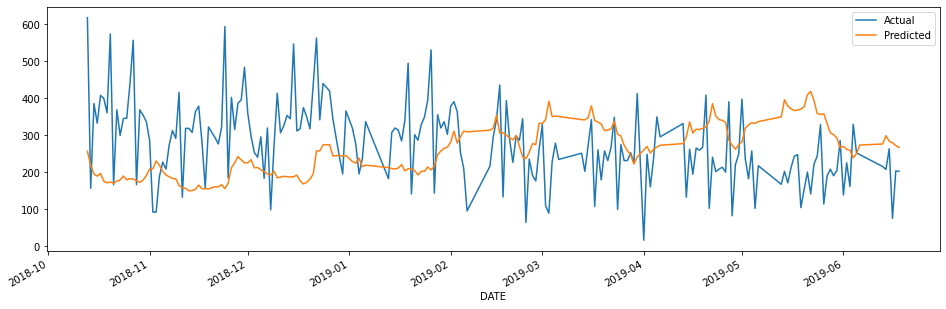

In [28]:
test_arima_pred['test'].plot(figsize=(16, 5), legend=True, label='Actual')
test_arima_pred['pred'].plot(legend=True, label='Predicted')
plt.show()

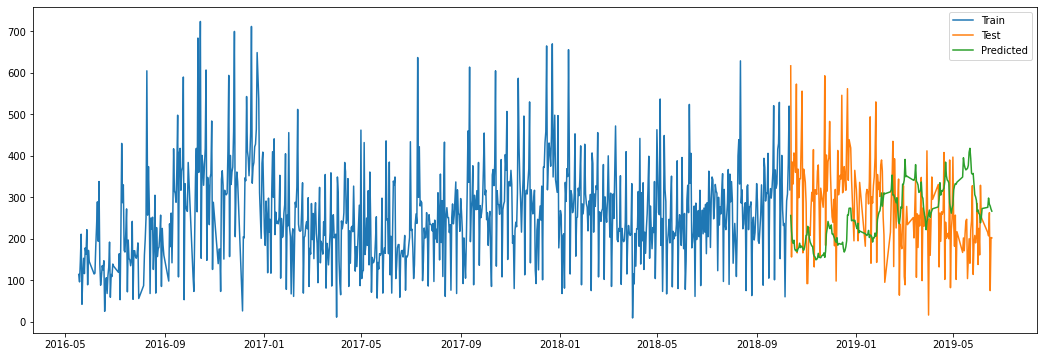

In [29]:
plt.figure(figsize=(18, 6))
plt.plot(salesbyday_train, label='Train')
plt.plot(salesbyday_test, label='Test')
plt.plot(test_arima_pred.pred, label='Predicted')
plt.legend()
plt.show()

In [30]:
pred_arima = model_arima.predict(n_periods=len(salesbyday_test)).tolist()
pred_arima_sliced = pred_arima[:len(salesbyday_test['QTY'])]
RMSE = np.sqrt(mean_squared_error(salesbyday_test['QTY'], pred_arima_sliced))
print('RMSE: %.4f' % RMSE)
MSE = mean_squared_error(salesbyday_test['QTY'], pred_arima_sliced)
print('MSE: %.4f' % MSE)
MAE = mean_absolute_error(salesbyday_test['QTY'], pred_arima_sliced)
print('MAE: %.4f' % MAE)
R2 = r2_score(salesbyday_test['QTY'], pred_arima_sliced)
print('R2 Score: %.4f' % R2)

RMSE: 145.8759
MSE: 21279.7720
MAE: 120.3118
R2 Score: -0.9135


**Differencing**

In [31]:
kpss_diffs = pm.arima.ndiffs(salesbyday_train['QTY'], alpha=0.05, test='kpss', max_d=10)
adf_diffs = pm.arima.ndiffs(salesbyday_train['QTY'], alpha=0.05, test='adf', max_d=10)
n_diffs = max(kpss_diffs, adf_diffs)
print(f"Optimized 'd' = {n_diffs}")

Optimized 'd' = 1


**Auto ARIMA**

In [32]:
model_auto_arima = pm.auto_arima(salesbyday_train,
                      #seasonal=True,
                      #m=7,
                      d=1,
                      max_p=6,
                      max_q=6,
                      max_P=6,
                      max_Q=6,
                      information_criterion='aic',
                      trace=True,
                      error_action='ignore',
                      stepwise=True,
                      suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10174.775, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10641.994, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10372.443, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10191.358, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10639.997, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10190.849, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10175.709, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=10169.060, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10173.724, Time=0.23 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=10170.744, Time=0.45 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=10155.188, Time=0.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=10177.712, Time=0.42 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=10155.521, Time=0.60 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=10164.951, Time=0.59 sec
 ARIMA(2,1,4)(0,0,0

In [33]:
print(model_auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  835
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -5051.867
Date:                Thu, 21 Dec 2023   AIC                          10125.734
Time:                        03:10:28   BIC                          10177.723
Sample:                             0   HQIC                         10145.667
                                - 835                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4530      0.086    -16.905      0.000      -1.621      -1.284
ar.L2         -1.0961      0.164     -6.687      0.000      -1.417      -0.775
ar.L3         -0.6295      0.172     -3.665      0.0

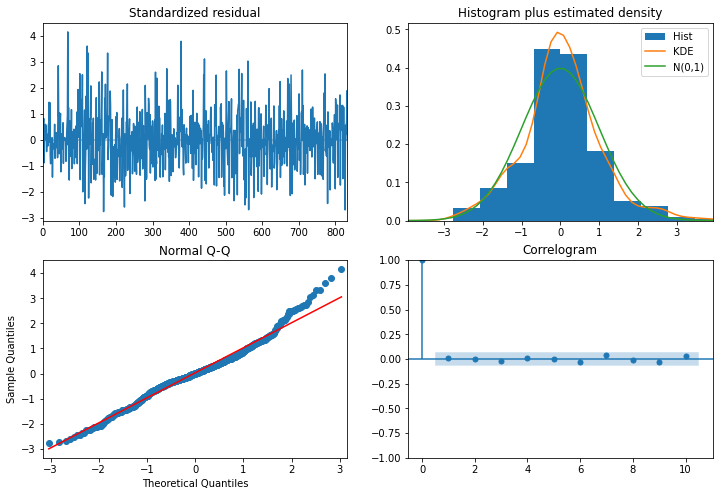

In [34]:
model_auto_arima.plot_diagnostics(figsize=(12,8))
plt.show()

In [35]:
pred_auto_list = model_auto_arima.predict(n_periods=len(salesbyday_test)).tolist()
pred_auto_list_sliced = pred_auto_list[:len(salesbyday_test)]
test_auto_pred = pd.DataFrame({'test': salesbyday_test['QTY'].values.tolist(), 'pred': pred_auto_list_sliced}, index=salesbyday_test.index)

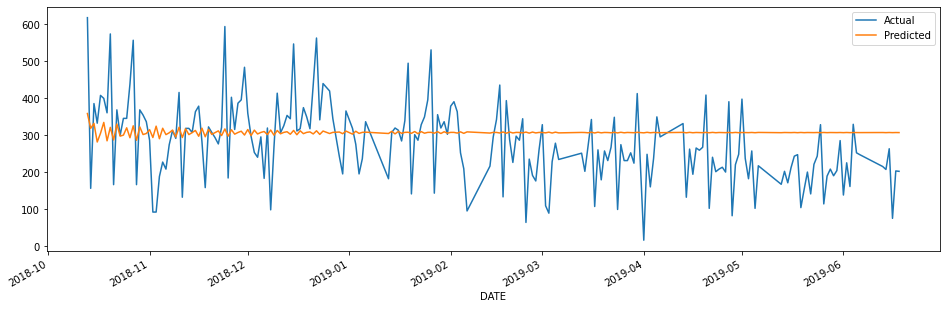

In [36]:
test_auto_pred['test'].plot(figsize=(16, 5), legend=True, label='Actual')
test_auto_pred['pred'].plot(legend=True, label='Predicted')
plt.show()

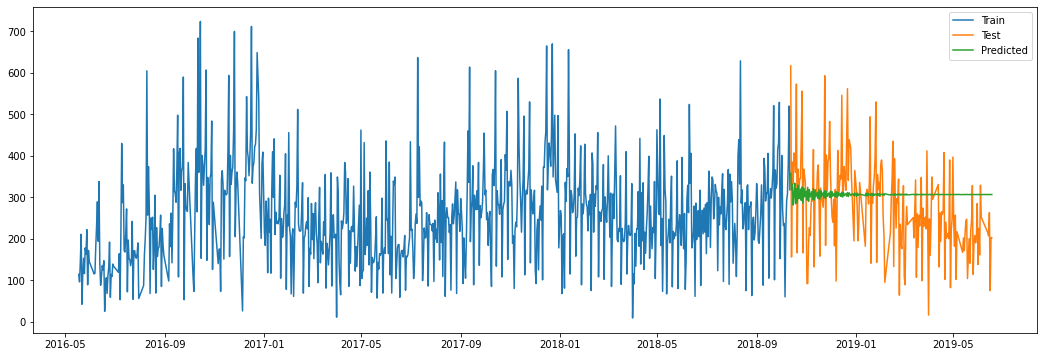

In [37]:
plt.figure(figsize=(18, 6))
plt.plot(salesbyday_train, label='Train')
plt.plot(salesbyday_test, label='Test')
plt.plot(test_auto_pred.pred, label='Predicted')
plt.legend()
plt.show()

In [38]:
pred_auto = model_auto_arima.predict(n_periods=len(salesbyday_test)).tolist()
pred_auto_sliced = pred_auto[:len(salesbyday_test['QTY'])]
RMSE = np.sqrt(mean_squared_error(salesbyday_test['QTY'], pred_auto_sliced))
print('RMSE: %.4f' % RMSE)
MSE = mean_squared_error(salesbyday_test['QTY'], pred_auto_sliced)
print('MSE: %.4f' % MSE)
MAE = mean_absolute_error(salesbyday_test['QTY'], pred_auto_sliced)
print('MAE: %.4f' % MAE)
R2 = r2_score(salesbyday_test['QTY'], pred_auto_sliced)
print('R2 Score: %.4f' % R2)

RMSE: 108.0742
MSE: 11680.0378
MAE: 85.4616
R2 Score: -0.0503


**SARIMA**

In [39]:
import itertools
import statsmodels.api as sm

p, d, q = 5, 1, 5
P, D, Q, m = range(3), range(2), range(3), 7  

seasonal_pdq = list(itertools.product(P, D, Q))

best_aic = float("inf")
best_param_seasonal = None

for param_seasonal in seasonal_pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(salesbyday_train,
                                        order=(p, d, q),
                                        seasonal_order=(param_seasonal[0],
                                        param_seasonal[1], param_seasonal[2], m),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        model_sarima = model.fit(disp=False, warn_convergence=False)
        current_aic = model_sarima.aic
        if current_aic < best_aic:
            best_aic = current_aic
            best_param_seasonal = param_seasonal
    except Exception as e:
        print(f"Exception: {e}")
        continue

print(f'Best Seasonal Parameters (Grid Search): {best_param_seasonal} - AIC: {best_aic}')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A dat

Best Seasonal Parameters (Grid Search): (2, 0, 2) - AIC: 9884.764294184524


In [40]:
#model_sarima = sm.tsa.statespace.SARIMAX(salesbyday_train, order=(5, 1, 5), seasonal_order=(2, 0, 2, 7)).fit()
print(model_sarima.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                    QTY   No. Observations:                  835
Model:             SARIMAX(5, 1, 5)x(2, 1, [1, 2], 7)   Log Likelihood               -4943.407
Date:                                Thu, 21 Dec 2023   AIC                           9916.814
Time:                                        03:11:29   BIC                           9987.214
Sample:                                             0   HQIC                          9943.847
                                                - 835                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5730      2.343     -0.245      0.807      -5.166       4.020
ar.

Plotting AR model


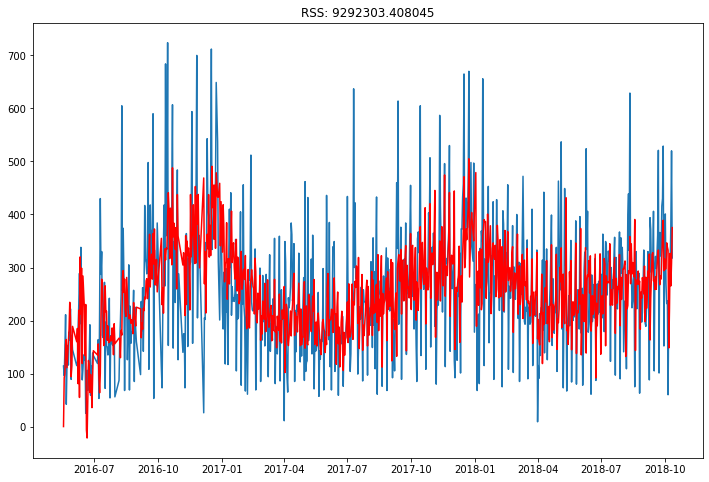

In [41]:
plt.plot(salesbyday_train)
plt.plot(model_sarima.fittedvalues, color='red')
plt.title('RSS: %4f'%sum((model_sarima.fittedvalues - salesbyday_train['QTY'])**2))
print('Plotting AR model')

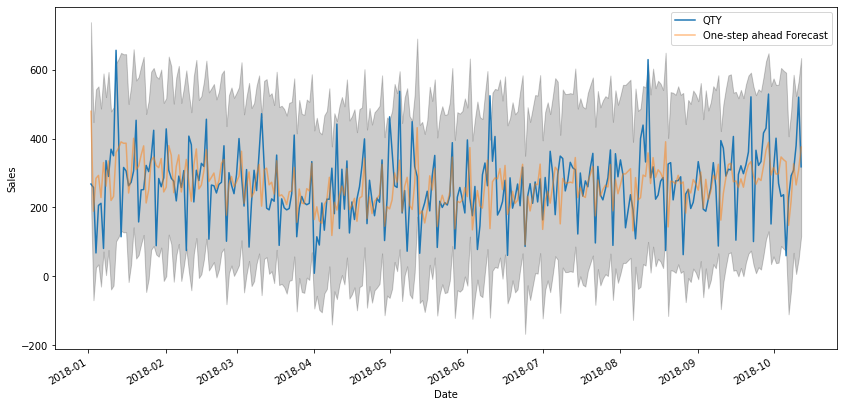

In [42]:
pred = model_sarima.get_prediction(start=pd.to_datetime('2018-01-02'), dynamic=False)
pred_ci = pred.conf_int()
ax = salesbyday_train['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.5, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

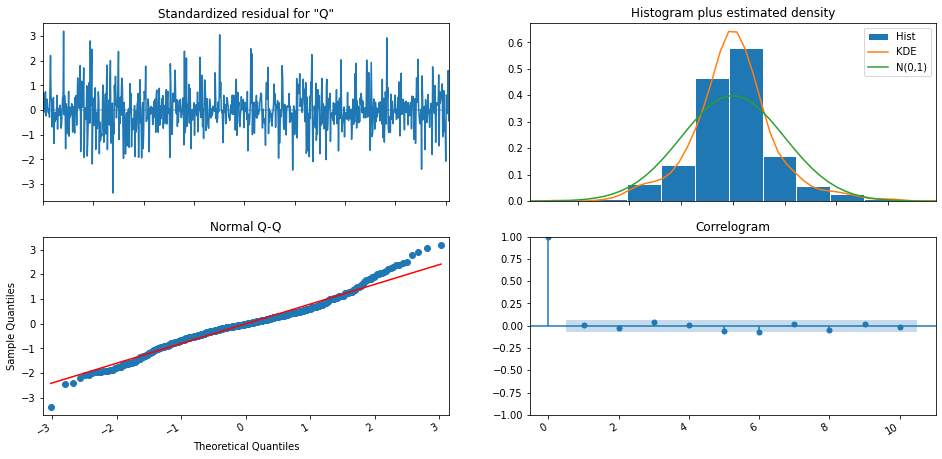

In [43]:
fig = model_sarima.plot_diagnostics(figsize=(16, 8))
fig.autofmt_xdate()
plt.show()

In [44]:
pred_sarima_list = model_sarima.predict(n_periods=len(salesbyday_test)).tolist()
pred_sarima_list_sliced = pred_sarima_list[:len(salesbyday_test)]
test_sarima_pred = pd.DataFrame({'test': salesbyday_test['QTY'].values.tolist(), 'pred': pred_sarima_list_sliced}, index=salesbyday_test.index)

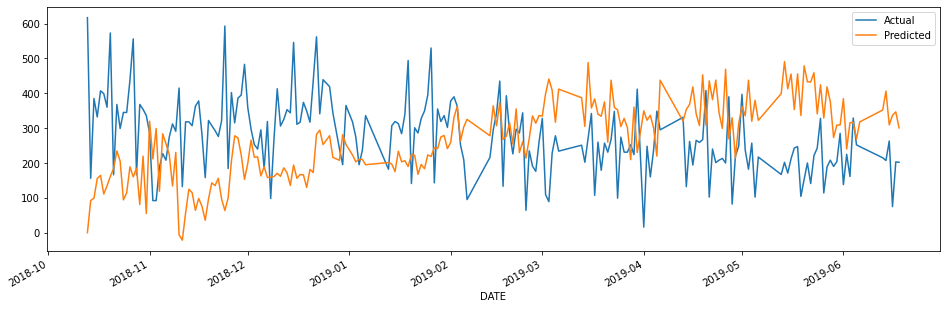

In [45]:
test_sarima_pred['test'].plot(figsize=(16, 5), legend=True, label='Actual')
test_sarima_pred['pred'].plot(legend=True, label='Predicted')
plt.show()

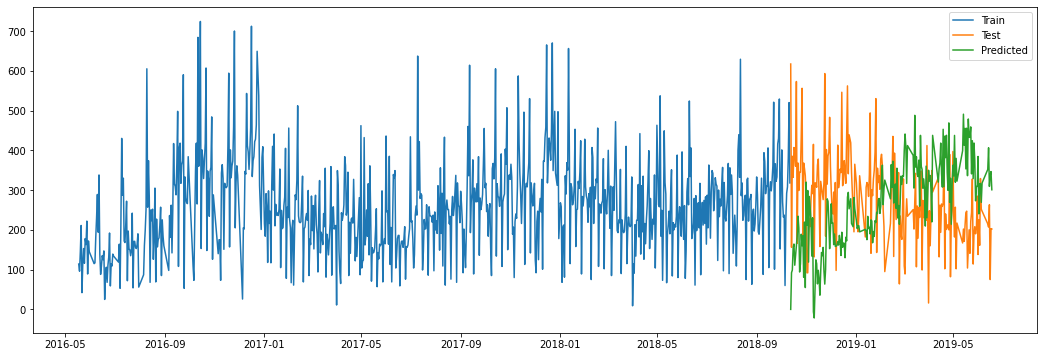

In [46]:
plt.figure(figsize=(18, 6))
plt.plot(salesbyday_train, label='Train')
plt.plot(salesbyday_test, label='Test')
plt.plot(test_sarima_pred.pred, label='Predicted')
plt.legend()
plt.show()

In [47]:
pred = model_sarima.predict(n_periods=len(salesbyday_test)).tolist()
pred_sarima_sliced = pred[:len(salesbyday_test['QTY'])]
RMSE = np.sqrt(mean_squared_error(salesbyday_test['QTY'], pred_sarima_sliced))
print('RMSE: %.4f' % RMSE)
MSE = mean_squared_error(salesbyday_test['QTY'], pred_sarima_sliced)
print('MSE: %.4f' % MSE)
MAE = mean_absolute_error(salesbyday_test['QTY'], pred_sarima_sliced)
print('MAE: %.4f' % MAE)
R2 = r2_score(salesbyday_test['QTY'], pred_sarima_sliced)
print('R2 Score: %.4f' % R2)

RMSE: 179.5781
MSE: 32248.2849
MAE: 147.8232
R2 Score: -1.8998


**Comparing Models**

In [48]:
def evaluate_model(model, test_data, model_name):
    pred = model.predict(n_periods=len(test_data)).tolist()
    pred_sliced = pred[:len(test_data['QTY'])]

    RMSE = np.sqrt(np.sqrt(mean_squared_error(test_data['QTY'], pred_sliced)))
    MSE = np.sqrt(mean_squared_error(test_data['QTY'], pred_sliced))
    MAE = np.sqrt(mean_absolute_error(test_data['QTY'], pred_sliced))
    R2 = r2_score(test_data['QTY'], pred_sliced)

    print(f"{model_name} Results:")
    print(f'RMSE: {RMSE:.4f}')
    print(f'MSE: {MSE:.4f}')
    print(f'MAE: {MAE:.4f}')
    print(f'R2 Score: {R2:.4f}')
    print()

evaluate_model(model_arima, salesbyday_test, 'ARIMA')
evaluate_model(model_auto_arima, salesbyday_test, 'AUTO ARIMA')
evaluate_model(model_sarima, salesbyday_test, 'SARIMA')

ARIMA Results:
RMSE: 12.0779
MSE: 145.8759
MAE: 10.9687
R2 Score: -0.9135

AUTO ARIMA Results:
RMSE: 10.3959
MSE: 108.0742
MAE: 9.2445
R2 Score: -0.0503

SARIMA Results:
RMSE: 13.4007
MSE: 179.5781
MAE: 12.1583
R2 Score: -1.8998

